# API development for download of Sentinel-2 and Landsat-8 data
### User defined mosaicing of harmonised products
_Robin Kohrs & Konstantin Schellenberg, February 2020, GEO 419_  
_Supervisor: John Truckenbrodt¹, Martin Habermeyer²_ <br>
<sub><sub>
¹ Friedrich-Schiller-University Jena, chair of remote sensing <br>
² Deutsches Luft- und Raumfahrtszentrum, earth observation center
</sub></sub>

## Tutorial
This is the extention for nasa_hls. We developed following new functions:

In order to make the program be more flexible, the goal of this extension is to
1. Download tiles by setting spatial (user defined verctor geometry) and temporal inqueries to the HLS server,
2. Mosaic the HDF4 formatted product per band and acquisition date.

As part of the module report will want to add the following post procession tasks: 
3. Calculate spectral indexes from the downloaded products.
4. Plot the results inline with `ipyleafet` and `folium` on a Open Street Map WMS service.

Tasks 1 and 2 are meant to work in accordance with the `nasa_hls` package and aims to lead to a pull request to the repository; 3 and 4 shall give an overview of to use the new utilities and the HLS product.

User guide to the HLS product:
https://hls.gsfc.nasa.gov/wp-content/uploads/2019/01/HLS.v1.4.UserGuide_draft_ver3.1.pdf

## <font color = "red"> Download HSL files with user input</font>

In [1]:
# change working directory 
# and set some user specific paths (don't forget the "/" at the end)
import os
os.chdir("/home/robin/uni/semester1/geo419/nasa_hls") 
shape_path = "/home/robin/uni/semester1/geo419/data/dummy_region.shp" #your shape
hdf_path = "/home/robin/uni/semester1/geo419/data/hdf/" #where  you want the hdfs
out_dir = "/home/robin/uni/semester1/geo419/data/hdf/" #where you want the final tiffs


In [2]:
%matplotlib inline

import nasa_hls
import sys
import pandas as pd
import os
from osgeo import gdal
import geopandas as gpd

import warnings
warnings.simplefilter("ignore")


pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)


- For testing purpose, try downloading the kml file:

In [3]:
nasa_hls.download_kml()

Creating new world UTM gird file in /home/robin/.nasa_hls/.auxdata/utm.kml


'/home/robin/.nasa_hls/.auxdata/utm.kml'

## <font color = "red">Make list with GeoDataFrames</font>

- This will serve as a conformation for the user
- It's a list of lists. Each inner list beeing the GeoDataFrames for the specified dates

In [12]:
ds = nasa_hls.make_tiles_dataset(shape=shape_path,
                                products=["S30", "L30"],
                                start_date="2019-07-01",
                                end_date="2019-07-15")

starting date: 2019-07-01
 
end date: 2019-07-15
 
     id                                           geometry
0  None  POLYGON ((20.67451 -28.49960, 21.20086 -28.356...
UTM tiles already successfully downloaded to:
 /home/robin/.nasa_hls/.auxdata/utm.kml 



  0%|          | 0/8 [00:00<?, ?it/s]


getting available datasets . . .


100%|██████████| 8/8 [00:09<00:00,  1.22s/it]


In [13]:
# print the list of lists
print(ds, "\n\n")

[    product   tile       date                                                url
140     S30  34JEN 2019-07-02  https://hls.gsfc.nasa.gov/data/v1.4/S30/2019/3...
347     S30  34JEP 2019-07-02  https://hls.gsfc.nasa.gov/data/v1.4/S30/2019/3...,     product   tile       date                                                url
35      S30  34JDN 2019-07-05  https://hls.gsfc.nasa.gov/data/v1.4/S30/2019/3...
141     S30  34JEN 2019-07-05  https://hls.gsfc.nasa.gov/data/v1.4/S30/2019/3...
243     S30  34JDP 2019-07-05  https://hls.gsfc.nasa.gov/data/v1.4/S30/2019/3...
348     S30  34JEP 2019-07-05  https://hls.gsfc.nasa.gov/data/v1.4/S30/2019/3...
439     L30  34JDN 2019-07-05  https://hls.gsfc.nasa.gov/data/v1.4/L30/2019/3...
484     L30  34JEN 2019-07-05  https://hls.gsfc.nasa.gov/data/v1.4/L30/2019/3...
529     L30  34JDP 2019-07-05  https://hls.gsfc.nasa.gov/data/v1.4/L30/2019/3...
574     L30  34JEP 2019-07-05  https://hls.gsfc.nasa.gov/data/v1.4/L30/2019/3...,     product   tile       

***
## <font color = "red">Download Tiles</font>

- Taking the list from above, the data sources can be downloaded via the function `download_tiles`. 

- This function calls `download_batch` and other methods internally in order to parse the right URLs for download.

- The path for the parameter `dir` needs to be adapted, as this is user-specific.

In [14]:
nasa_hls.download_tiles(dstdir=hdf_path,
                        dataframes=ds)

100%|██████████| 4/4 [03:59<00:00, 59.93s/it]


In [3]:
# show the name for the first downloaded file
hdfs = [f for f in os.listdir(hdf_path) if ".hdf" in f]    
first_hdf = os.listdir(hdf_path)[0]
print(first_hdf)

HLS.L30.T34JDN.2019193.v1.4.hdf


In [4]:
# the size of one ".hdf"-file
hdfs = [f for f in os.listdir(hdf_path) if f.endswith(".hdf")]
s = os.path.getsize(os.path.join(hdf_path, hdfs[0]))
print("The first downloaded 'hdf'-file is {0:.2f} MB in size on the disk".format(s/1e6))

The first downloaded 'hdf'-file is 147.36 MB in size on the disk


***
## <font color = "red">Mosaicing tiles</font>
- Now we'll create a mosaic for each day. Internally there are two steps. First creating a mosaic for each band for each day. And afterwards creating a mosaic for each day of all the single bands.
- This is done by the function `make_mosaic`.
- One could omit the specification of the `shape`-parameter and get as final output an uncropped mosaic of the hls-scenes

In [17]:
# %%capture
#bands is set to None in order to use all bands
# as we downloaded Sentinel-Scenes, the argument `products` is given the paramter "S30"
nasa_hls.make_mosaic(srcdir=hdf_path, dstdir=out_dir, product="S30", shape = shape_path)

Sentinel
/home/robin/.nasa_hls/.auxdata/mosaic/bands/191B01.vrt
/home/robin/uni/semester1/geo419/data/hdf/S30_2019_191.tif
--------------------------------------------------------------------------------

1.GEOTiff
Final VRT: 
 /home/robin/.nasa_hls/.auxdata/mosaic/days/S30_2019_191final.vrt
Outfile: 
 /home/robin/uni/semester1/geo419/data/hdf/S30_2019_191.tif 

cmd call: 
 gdalwarp -srcnodata -1000 -cutline /home/robin/uni/semester1/geo419/data/dummy_region.shp /home/robin/.nasa_hls/.auxdata/mosaic/days/S30_2019_191final.vrt /home/robin/uni/semester1/geo419/data/hdf/S30_2019_191.tif 


/home/robin/.nasa_hls/.auxdata/mosaic/bands/186B01.vrt
/home/robin/uni/semester1/geo419/data/hdf/S30_2019_186.tif
--------------------------------------------------------------------------------

2.GEOTiff
Final VRT: 
 /home/robin/.nasa_hls/.auxdata/mosaic/days/S30_2019_186final.vrt
Outfile: 
 /home/robin/uni/semester1/geo419/data/hdf/S30_2019_186.tif 

cmd call: 
 gdalwarp -srcnodata -1000 -cutline /ho

***
## <font color = "red">Print Results</font>

In [5]:
# user- filepath of one of the rasters (hdf-scenes)
fp = "/home/robin/uni/semester1/geo419/data/hdf/S30_2019_186.tif"

In [6]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import rasterio as rio
from rasterio.plot import show
from rasterio.plot import show_hist

In [7]:
#print dimensions of raster
rio_raster = rio.open(fp) #produces rasterio.DatasetReader
print(type(rio_raster) )
print(rio_raster.bounds)

<class 'rasterio.io.DatasetReader'>
BoundingBox(left=399960.0, bottom=-3309780.0, right=609780.0, top=-3099960.0)


In [8]:
# load it into a numpy array
with rio.open(fp) as src:
    rio_data = src.read() # produces numpy nd array
    rio_meta = src.profile

print(type(rio_data))
# Confirm that there are 12 bands for Sentinel Scenes
print(rio_data.shape)

<class 'numpy.ndarray'>
(14, 6994, 6994)


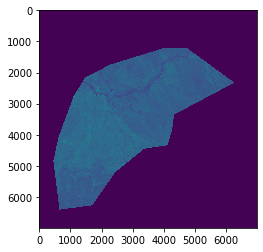

In [10]:
# show first band cropped to our shapefile
show((rio_data[0,:,:]))

In [19]:
# read the shape and reproject it
shape = gpd.read_file(shape_path)
print(shape.crs)
shape = shape.to_crs("EPSG:32634")
print(shape.crs)

{'init': 'epsg:4326'}


RuntimeError: b'no arguments in initialization list'

### get some metadata

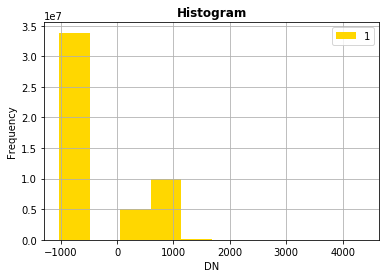

In [20]:
# takes waaayy to long
show_hist((rio_raster, 1), lw = 0.0)

In [6]:
# the hls-products come with -1000 as no-data-value for all bands, except the QA-Band
# how many values with -1000 are in the first band
first_band_array = rio_data[0,:,:]
sum_neg = (first_band_array == -1000).sum()
sum_neg 

33851751

In [22]:
# just for conformation:
# what are  datatype and the nodata-values in the final tiff
# tiff doesn't support seperate no-data values for each band:(
for i, dtype, nodataval in zip(rio_raster.indexes, rio_raster.dtypes, rio_raster.nodatavals):
    print(i, dtype, nodataval)

1 int16 -1000.0
2 int16 -1000.0
3 int16 -1000.0
4 int16 -1000.0
5 int16 -1000.0
6 int16 -1000.0
7 int16 -1000.0
8 int16 -1000.0
9 int16 -1000.0
10 int16 -1000.0
11 int16 -1000.0
12 int16 -1000.0
13 int16 -1000.0
14 int16 -1000.0


In [23]:
# in the vrt one can see that the 12th band has a no-data value of -255
# this is the QA-Layer which has a depth of just 8 bit
for i, dtype, nodataval in zip(raster_vrt.indexes, raster_vrt.dtypes, raster_vrt.nodatavals):
    print(i, dtype, nodataval)

1 int16 -1000.0
2 int16 -1000.0
3 int16 -1000.0
4 int16 -1000.0
5 int16 -1000.0
6 int16 -1000.0
7 int16 -1000.0
8 int16 -1000.0
9 int16 -1000.0
10 int16 -1000.0
11 int16 -1000.0
12 int16 -1000.0
13 int16 -1000.0
14 uint8 255.0


***
## <font color="red"> Visualize RGB (seperately and stacked) </font>

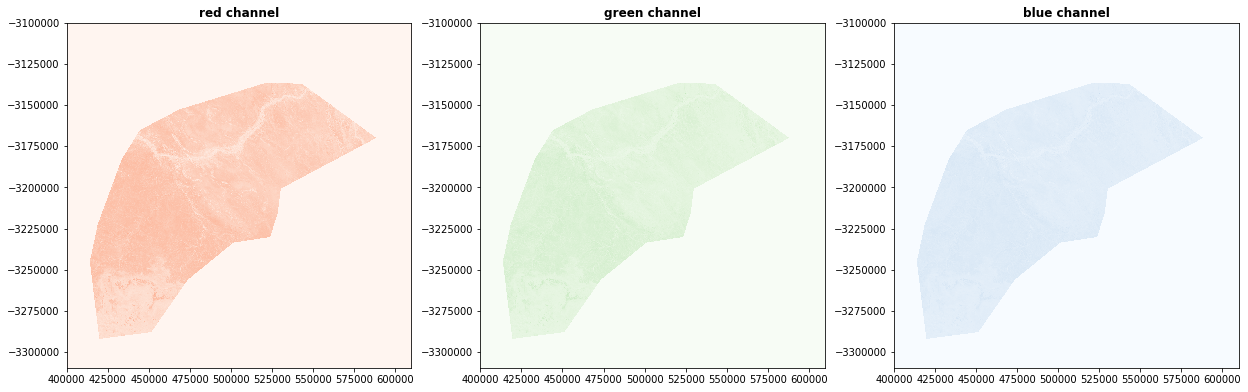

In [24]:
fig, (axr, axg, axb) = plt.subplots(1,3, figsize=(21,7))
show((rio_raster,4), ax = axr, cmap = "Reds", title = "red channel")
show((rio_raster,3), ax = axg, cmap = "Greens", title = "green channel")
show((rio_raster,2), ax = axb, cmap = "Blues", title = "blue channel" )


In [25]:
# read single bands as np.ndarrays
red = rio_raster.read(4)
green = rio_raster.read(3)
blue = rio_raster.read(2)
nir = rio_raster.read(7)
red_edge_1 = rio_raster.read(5)
red_edge_2 = rio_raster.read(6)
swir_2 = rio_raster.read(11)

In [26]:
# convert ints to floats
red_array = red.astype("float")
green_array = green.astype("float")
blue_array = blue.astype("float")
nir_array = nir.astype("float")
red_edge_1 = red_edge_1.astype("float")
red_edge_2 = red_edge_2.astype("float")

In [19]:
# cast -1000 to na
red_array[red_array == -1000] = np.NAN
green_array[green_array == -1000] = np.NAN
blue_array[blue_array == -1000] = np.NAN
nir_array[nir_array == -1000] = np.NAN

In [27]:
# function for visualizing the rgb
def normalize(array):
    """Normalizes numpy arrays into scale 0.0 - 1.0"""
    array_min, array_max = array.min(), array.max()
    return ((array - array_min)/(array_max - array_min))

redn = normalize(red)
greenn = normalize(green)
bluen = normalize(blue)
nirn = normalize(nir)


print("Normalized bands")
print(redn.min(), '-', redn.max(), 'mean:', redn.mean())
print(greenn.min(), '-', greenn.max(), 'mean:', greenn.mean())
print(bluen.min(), '-', bluen.max(), 'mean:', bluen.mean())
print(nirn.min(), '-', nirn.max(), 'mean:', nirn.mean())


Normalized bands
0.0 - 1.0 mean: 0.05753233157319345
0.0 - 1.0 mean: 0.044277830691636016
0.0 - 1.0 mean: 0.03549793401864126
0.0 - 1.0 mean: 0.07707195115455066


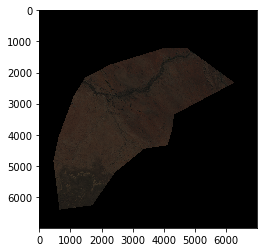

In [28]:
# stack rgb bands together
rgb = np.dstack((redn, greenn, bluen))
plt.imshow(rgb)

***
## <font color = "red">Calculate NDVI </font>

In [29]:
# Allow division by zero
np.seterr(divide='ignore', invalid='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [30]:
# setup array of just 0s
ndvi = np.zeros(red_array.shape, dtype=rio.float32)

In [31]:
check = np.logical_and(nir > 0, red > 0)
ndvi = np.where(check, (nir - red) / (nir + red), np.NAN)

In [32]:
# save the ndvi
# Set spatial characteristics of the output object to mirror the input
kwargs = src.meta
kwargs.update(dtype = rio.float32,
             count = 1,
             nodata = -1000)

# Create the file
with rio.open(os.path.join(out_dir,'ndvi.tif'), 'w', **kwargs) as dst:
        dst.write_band(1, ndvi.astype(rio.float32))

In [34]:
with rio.open(os.path.join(out_dir,'ndvi.tif')) as src2:
    ndvi_data = src2.read()
    ndvi_meta = src2.meta

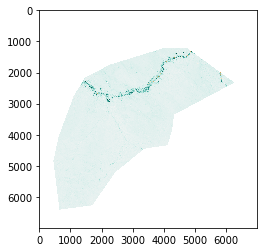

In [35]:
show(ndvi_data[0,:,:], cmap = "BrBG")

***
## <font color = "red">Calculate NDWI </font>

In [36]:
# setup array of just 0s
ndwi = np.zeros(red_array.shape, dtype=rio.float32)

In [37]:
check = np.logical_and(nir > 0, green > 0)
ndwi = np.where(check, (green - nir) / (nir + green), np.NAN)

In [38]:
# save the ndwi
# Set spatial characteristics of the output object to mirror the input
kwargs = src.meta
kwargs.update(dtype = rio.float32,
             count = 1,
             nodata = -1000)

# Create the file
with rio.open(os.path.join(out_dir,'ndwi.tif'), 'w', **kwargs) as dst:
        dst.write_band(1, ndwi.astype(rio.float32))

In [39]:
with rio.open(os.path.join(out_dir,'ndwi.tif')) as src3:
    ndwi_data = src3.read()
    ndwi_meta = src3.meta

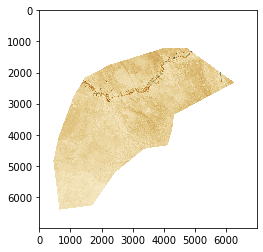

In [40]:
show(ndwi_data[0,:,:], cmap = "BrBG")

***
## <font color = "red">Calculate SLAWI </font>

In [41]:
# setup array of just 0s
slavi = np.zeros(red_array.shape, dtype=rio.float32)

In [42]:
check = np.logical_and(nir > 0, swir_2 > 0, nir > 0)
slavi = np.where(check, ((nir) / (red + swir_2)), np.NAN)

In [43]:
# save the slavi
# Set spatial characteristics of the output object to mirror the input
kwargs = src.meta
kwargs.update(dtype = rio.float32,
             count = 1,
             nodata = -1000)

# Create the file
with rio.open(os.path.join(out_dir,'slavi.tif'), 'w', **kwargs) as dst:
        dst.write_band(1, slavi.astype(rio.float32))

In [44]:
with rio.open(os.path.join(out_dir,'slavi.tif')) as src3:
    slavi_data = src3.read()
    slavi_meta = src3.meta

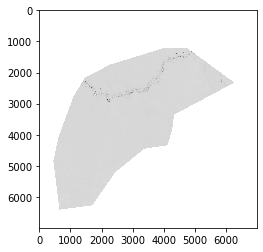

In [45]:
show(slavi_data[0,:,:], cmap = "Greys")

***
## <font color = "red"> Plot with Folium </font>

In [46]:
import folium
from folium import plugins

In [47]:
# check crs (needs to be reprojected to be plotted with folium)
src2 = rio.open(os.path.join(out_dir,'ndvi.tif'))
src3 = rio.open(os.path.join(out_dir,'ndwi.tif'))
print(src2.crs)
print(src3.crs)

EPSG:32634
EPSG:32634


In [48]:
# Create variables for destination coordinate system and the name of the projected raster
dst_crs = 'EPSG:4326' 
in_path_ndvi = os.path.join(out_dir, "ndvi.tif")
in_path_ndwi = os.path.join(out_dir, "ndwi.tif")
in_path_slavi = os.path.join(out_dir, "slavi.tif")
out_path_ndvi = os.path.join(out_dir, "repr_ndvi.tif")
out_path_ndwi = os.path.join(out_dir, "repr_ndwi.tif")
out_path_slavi = os.path.join(out_dir, "repr_slavi.tif")

In [49]:
from rasterio.warp import calculate_default_transform, reproject, Resampling

In [50]:
# reproject ndvi
with rio.open(in_path_ndvi) as src:
    transform, width, height = calculate_default_transform(
        src.crs, dst_crs, src.width, src.height, *src.bounds)
    kwargs = src.meta.copy()
    kwargs.update({
        'crs': dst_crs,
        'transform': transform,
        'width': width,
        'height': height,
        'nodata': -1000
    })
    with rio.open(out_path_ndvi, 'w', **kwargs) as dst:
        for i in range(1, src.count + 1):
            reproject(
            source=rio.band(src, i),
            destination=rio.band(dst, i),
            src_transform=src.transform,
            src_crs=src.crs,
            dst_transform=transform,
            dst_crs=dst_crs,
            resampling=Resampling.nearest)

In [51]:
# reproject ndwi
with rio.open(in_path_ndwi) as src:
    transform, width, height = calculate_default_transform(
        src.crs, dst_crs, src.width, src.height, *src.bounds)
    kwargs = src.meta.copy()
    kwargs.update({
        'crs': dst_crs,
        'transform': transform,
        'width': width,
        'height': height,
        'nodata': -1000
    })
    with rio.open(out_path_ndwi, 'w', **kwargs) as dst:
        for i in range(1, src.count + 1):
            reproject(
            source=rio.band(src, i),
            destination=rio.band(dst, i),
            src_transform=src.transform,
            src_crs=src.crs,
            dst_transform=transform,
            dst_crs=dst_crs,
            resampling=Resampling.nearest)


In [52]:
# reproject slavi
with rio.open(in_path_slavi) as src:
    transform, width, height = calculate_default_transform(
        src.crs, dst_crs, src.width, src.height, *src.bounds)
    kwargs = src.meta.copy()
    kwargs.update({
        'crs': dst_crs,
        'transform': transform,
        'width': width,
        'height': height,
        'nodata': -1000
    })
    with rio.open(out_path_slavi, 'w', **kwargs) as dst:
        for i in range(1, src.count + 1):
            reproject(
            source=rio.band(src, i),
            destination=rio.band(dst, i),
            src_transform=src.transform,
            src_crs=src.crs,
            dst_transform=transform,
            dst_crs=dst_crs,
            resampling=Resampling.nearest)


In [53]:
# Use rasterio to import the reprojected data as img
with rio.open(out_path_ndvi) as src2:
    boundary = src2.bounds
    ndvi_data = src2.read()
    nodata = src2.nodata
with rio.open(out_path_ndwi) as src3:
    ndwi_data = src3.read()
with rio.open(out_path_slavi) as src4:
    slavi_data = src4.read()

In [54]:
shape = ndvi_data.shape[1:3]

In [55]:
# make them a 2d array
ndvi_data = ndvi_data.reshape(shape)
ndwi_data = ndwi_data.reshape(shape)
slavi_data = slavi_data.reshape(shape)

In [56]:
# make nan to zeros
ndvi_data[ndvi_data == -1000] = np.NAN
ndwi_data[ndwi_data == -1000] = np.NAN
slavi_data[slavi_data == -1000] = np.NAN

In [57]:
# save them as png
plt.imsave(os.path.join(out_dir,"ndvi.png"), ndvi_data, cmap=plt.cm.viridis, vmin = -1, vmax = 1)
plt.imsave(os.path.join(out_dir,"ndwi.png"), ndwi_data, cmap=plt.cm.viridis, vmin = -1, vmax = 1)
plt.imsave(os.path.join(out_dir,"slavi.png"), slavi_data, cmap=plt.cm.viridis, vmin = -1, vmax = 1)

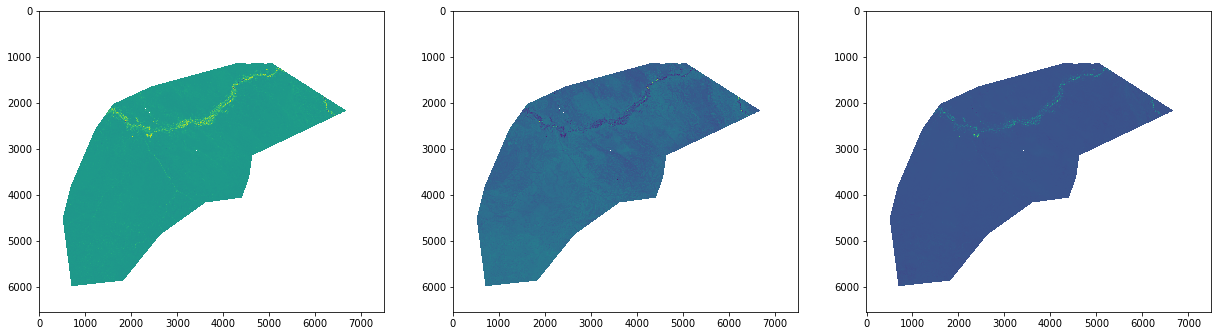

In [58]:
fig, axs = plt.subplots(1,3, figsize = (21,7))
axs[0].imshow(ndvi_data)
axs[1].imshow(ndwi_data)
axs[2].imshow(slavi_data)

In [59]:
# make bounding box
left = boundary[0]
bottom = boundary[1]
right = boundary[2]
top = boundary[3]
print("left:", left)
print("bottom:", bottom)
print("right:", right)
print("top:", top)


left: 19.96366797192763
bottom: -29.918757934481064
right: 22.13724617529474
top: -28.02035658743671


In [60]:
ndvi_data.flags.writeable = False
ndwi_data.flags.writeable = False

In [61]:
m = folium.Map(location=[-29, 20],
                  tiles='Stamen Terrain', zoom_start = 8)

In [434]:
def get_color(x):
    decimals = 2
    x = np.around(x, decimals=decimals)
    if x != -1000:
        return cm.get_cmap('viridis')
    elif x==-1000:
        return (0, 0, 0, 0)
    else:
        raise ValueError()

In [65]:
rasterlayer = folium.FeatureGroup(name = "ndvi")
rasterlayer.add_child(folium.raster_layers.ImageOverlay(
                        image= os.path.join(out_dir,"ndvi.png"),
                        bounds=[[bottom, left], [top, right]],
                        interactive=True,
                        cross_origin=False,
                        zindex=1
                            ))
rasterlayer2 = folium.FeatureGroup(name = "ndwi")
rasterlayer2.add_child(folium.raster_layers.ImageOverlay(
                        image= os.path.join(out_dir,"ndwi.png"),
                        bounds=[[bottom, left], [top, right]],
                        interactive=True,
                        cross_origin=False,
                        zindex=1
                            ))


In [67]:
# m.add_child(rasterlayer)
m.add_child(rasterlayer2, rasterlayer)
m.add_child(folium.LayerControl())
m.save(os.path.join(out_dir, "test.html"))